---
title: AERO 417 Project 1
---

In [1]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sy

In [81]:
# Input Constraints
takeoff_thrust = 12000
pressure_ambient = 1.01
temperature_ambient = 288

P_compressor = 4.15
m_dot = 20
turbine_inlet_temperature = 1100

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.9
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

# Design Variables
N = 250
U_tip = 355.3
C_axial = 150
rr_rt = 0.5

In [ ]:
# Constant Mean Radius

T01 = temperature_ambient
P01 = pressure_ambient
C1 = C_axial

T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

inlet_radius_tip = (m_dot/(np.pi*rho1*C1)/(1-rr_rt**2))**0.5
inlet_radius_root = rr_rt*inlet_radius_tip
inlet_radius_mean = (inlet_radius_tip+inlet_radius_root)/2

V1_tangent = (U_tip**2+C_axial**2)**0.5
a1 = (gamma*R*T1)**0.5
M1 = V1_tangent/a1

C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2

outlet_radius_mean = inlet_radius_mean
h = A2/2/np.pi/outlet_radius_mean
outlet_radius_tip = outlet_radius_mean+h/2
outlet_radius_root = outlet_radius_mean-h/2

print("Geometry:")
print("Inlet")
print("Tip-",inlet_radius_tip)
print("Root-",inlet_radius_root)
print("Mean-",inlet_radius_mean)
print("Outlet")
print("Tip-",outlet_radius_tip)
print("Root-",outlet_radius_root)
print("Mean-",outlet_radius_mean)

U_mean = 2*np.pi*N*outlet_radius_mean
Beta1 = np.arctan(U_mean/C_axial)
V1 = C_axial/np.cos(Beta1)
V2 = 0.72*V1
Beta2 = np.arccos(C_axial/V2)

ideal_temperature_rise = U_mean*C_axial*(np.tan(Beta1)-np.tan(Beta2))/Cp
num_stages = int(np.ceil((T2-T1)/ideal_temperature_rise)+1)

tips = np.linspace(inlet_radius_tip,outlet_radius_tip,num_stages)
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
means = [(t+r)/2 for t,r in zip(tips,roots)]

x = range(1,num_stages+1)

plt.figure()
plt.plot(x,tips,label="Tip Radius")
plt.plot(x,roots,label="Root Radius")
plt.plot(x,means,label="Mean Radius")
plt.legend()
plt.xticks(x)
plt.xlabel("Stage Number")
plt.ylabel("length (m)")
plt.title("Constant Mean Radius Geometry View")
plt.show()

mean_temperature_rise = (T2-T1)/num_stages

min_temperature_rise = mean_temperature_rise-mean_temperature_rise%(np.ceil(mean_temperature_rise/5))
max_temperature_rise = ((T2-T1)-2*min_temperature_rise)/(num_stages-2)
temperature_rise = []
temperature_rise.append(min_temperature_rise)
temperature_rise.extend((num_stages-2)*[max_temperature_rise])
temperature_rise.append(min_temperature_rise)

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]

C1_swirl = [0]

swirl_change = Cp*temperature_rise[0]/work_done[0]/U_mean
C2_swirl = [C1_swirl[-1]+swirl_change]

Beta1 = np.arctan(U_mean/C_axial)
Alpha1 = np.arctan(C1_swirl[-1]/C_axial)
Beta2 = np.arctan((U_mean-C2_swirl[-1])/C_axial)
Alpha2 = np.arctan(C2_swirl[-1]/C_axial)

De_Haller = [np.cos(Beta1)/np.cos(Beta2)]

P_ratio = [(1+compressor_polytropic_efficiency*temperature_rise[0]/T01)**(gamma/(gamma-1))]

Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[-1]*P01]

Inlet_T0 = [T01]
Outlet_T0 = [T01+temperature_rise[0]]

Lambda = [1-(C2_swirl[-1]+C1_swirl[-1])/2/U_mean,0.7]
Lambda.extend((num_stages-2)*[0.5])

def beta_equations(x,idx):
    return [temperature_rise[idx]*Cp/work_done[idx]/U_mean/C_axial-(np.tan(x[0])-np.tan(x[1])),
            Lambda[idx]/C_axial*2*U_mean-(np.tan(x[0])+np.tan(x[1]))]

for stage_num in range(1,num_stages):
    Beta1,Beta2 = fsolve(beta_equations,[1,1],args=stage_num)
    Alpha1 = np.arctan(U_mean/C_axial-np.tan(Beta1))
    Alpha2 = np.arctan(U_mean/C_axial-np.tan(Beta2))
    C1_swirl.append(C_axial*np.tan(Alpha1))
    C2_swirl.append(C_axial*np.tan(Alpha2))
    De_Haller.append(np.cos(Beta1)/np.cos(Beta2))
    P_ratio.append((1+compressor_polytropic_efficiency*temperature_rise[stage_num]/Outlet_T0[-1])**(gamma/(gamma-1)))
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1]*Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1]+temperature_rise[stage_num])
    
df = {"Inlet_T0":Inlet_T0,"Outlet_T0":Outlet_T0,"Inlet_P0":Inlet_P0,"Outlet_P0":Outlet_P0,"P_ratio":P_ratio,"Inlet_swirl":C1_swirl,"Outlet_swirl":C2_swirl,"De_Haller":De_Haller}
df = pd.DataFrame(df)
df.index+=1
df

In [20]:
# Input Constraints
takeoff_thrust = 5096
pressure_ambient = 1.01325
temperature_ambient = 288.15

P_compressor = 5
m_dot = 8.10
turbine_inlet_temperature = 1173

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.89
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

# Design Variables
N = 25650/60/2/np.pi
rr_rt = 0.4
M1 = 0.5
M2 = 0.26

num_stages = 5

In [21]:
C_a = sy.Symbol("C_a")

T01 = temperature_ambient
P01 = pressure_ambient
C1 = C_a

T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

inlet_radius_tip = (m_dot/(np.pi*rho1*C1)/(1-rr_rt**2))**0.5
inlet_radius_root = rr_rt*inlet_radius_tip
inlet_radius_mean = (inlet_radius_tip+inlet_radius_root)/2

a1 = (gamma*R*T1)**0.5
V1_tangent = M1*a1

C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
a2 = (gamma*R*T2)**0.5
V2_tangent = M2*a2

P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2

outlet_radius_tip = inlet_radius_tip
outlet_radius_root = (outlet_radius_tip**2-A2/np.pi)**0.5
outlet_radius_mean = (outlet_radius_tip+outlet_radius_root)/2

U_mean_1 = N * inlet_radius_mean*2*np.pi
U_mean_2 = N * outlet_radius_mean*2*np.pi
V1_t = (U_mean_1**2+C_a**2)**0.5
V2_t = (U_mean_2**2+C_a**2)**0.5
print(V1_t-V1_tangent)
print(V2_t-V2_tangent)

# print(sy.solve(V1_t-V1_tangent,C_a))
# print(sy.solve(V2_t-V2_tangent,C_a))

-170.131324276278*(1 - 1.72657448485492e-6*C_a**2)**0.5 + 27.9026037279818*(0.00128443028604137*C_a**2 + ((288.15 - C_a**2/2010)/(C_a*(1.0 - 1.72657448485492e-6*C_a**2)**3.5))**1.0)**0.5
-114.546506488417*(1 - 1.02990430678417e-6*C_a**2)**0.5 + 19.9304312342727*(0.00251748336064109*C_a**2 + (((288.15 - C_a**2/2010)/(C_a*(1.0 - 1.72657448485492e-6*C_a**2)**3.5))**0.5 + (((288.15 - C_a**2/2010)/(C_a*(1.0 - 1.72657448485492e-6*C_a**2)**3.5))**1.0 - 0.168*(483.06666409077 - C_a**2/2010)/(C_a*(1 - 1.02990430678417e-6*C_a**2)**3.5))**0.5)**2)**0.5


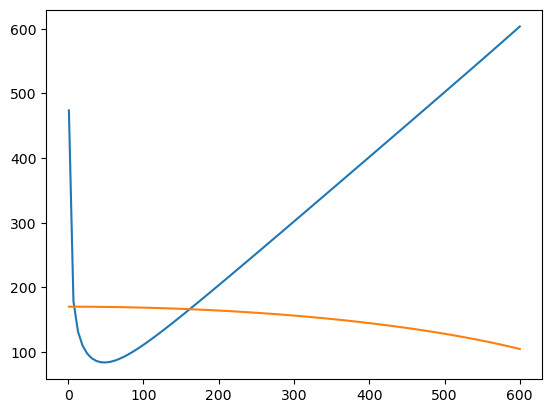

In [22]:
plt.figure()
x = np.linspace(1,600,100)
plt.plot(x,[V1_t.subs(C_a,val) for val in x])
plt.plot(x,[V1_tangent.subs(C_a,val) for val in x])
plt.show()

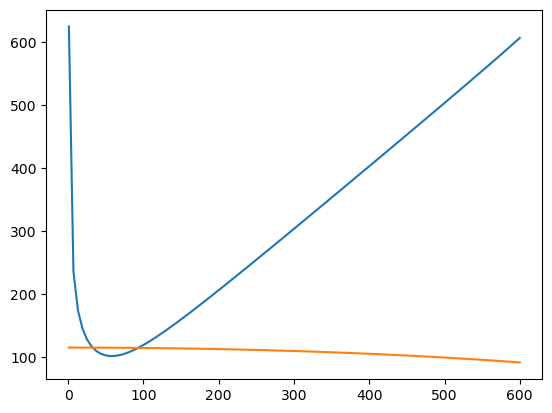

In [23]:
plt.figure()
x = np.linspace(1,600,100)
plt.plot(x,[V2_t.subs(C_a,val) for val in x])
plt.plot(x,[V2_tangent.subs(C_a,val) for val in x])
plt.show()

In [ ]:
# Constant Outer Diameter







print("Geometry:")
print("Inlet")
print("Tip-",inlet_radius_tip)
print("Root-",inlet_radius_root)
print("Mean-",inlet_radius_mean)
print("Outlet")
print("Tip-",outlet_radius_tip)
print("Root-",outlet_radius_root)
print("Mean-",outlet_radius_mean)

tips = np.linspace(inlet_radius_tip,outlet_radius_tip,num_stages)
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
means = [(t+r)/2 for t,r in zip(tips,roots)]
U_mean = [2*np.pi*N*m for m in means]

x = range(1,num_stages+1)

plt.figure()
plt.plot(x,tips,label="Tip Radius")
plt.plot(x,roots,label="Root Radius")
plt.plot(x,means,label="Mean Radius")
plt.legend()
plt.xticks(x)
plt.xlabel("Stage Number")
plt.ylabel("length (m)")
plt.title("Constant Mean Radius Geometry View")
plt.show()


Beta1 = np.arctan(U_mean[0]/C_axial)
V1 = C_axial/np.cos(Beta1)
V2 = 0.72*V1
Beta2 = np.arccos(C_axial/V2)

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]

temperature_rise = [(T02-T01)/5 for _ in range(num_stages)]

C1_swirl = [0]
swirl_change = (Cp*temperature_rise[0]/work_done[0]+U_mean[0]*C1_swirl[-1])/U_mean[1]
C2_swirl = [C1_swirl[-1]+swirl_change]

Beta1 = np.arctan(U_mean[0]/C_axial)
Alpha1 = np.arctan(C1_swirl[-1]/C_axial)
Beta2 = np.arctan((U_mean[0]-C2_swirl[-1])/C_axial)
Alpha2 = np.arctan(C2_swirl[-1]/C_axial)

De_Haller = [np.cos(Beta1)/np.cos(Beta2)]

P_ratio = [(1+compressor_polytropic_efficiency*temperature_rise[0]/T01)**(gamma/(gamma-1))]

Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[-1]*P01]

Inlet_T0 = [T01]
Outlet_T0 = [T01+temperature_rise[0]]

Lambda = [1-(C2_swirl[-1]+C1_swirl[-1])/2/U_mean[0],0.7]
Lambda.extend((num_stages-2)*[0.5])

def beta_equations(x,idx):
    return [temperature_rise[idx]*Cp/work_done[idx]/C_axial/U_mean[idx]-(np.tan(x[0])-np.tan(x[1])),
            Lambda[idx]/C_axial*2*U_mean[idx]-(np.tan(x[0])+np.tan(x[1]))]

for stage_num in range(1,num_stages):
    Beta1,Beta2 = fsolve(beta_equations,[1,1],args=stage_num)
    Alpha1 = np.arctan(U_mean[stage_num]/C_axial-np.tan(Beta1))
    Alpha2 = np.arctan(U_mean[stage_num]/C_axial-np.tan(Beta2))
    C1_swirl.append(C_axial*np.tan(Alpha1))
    C2_swirl.append(C_axial*np.tan(Alpha2))
    De_Haller.append(np.cos(Beta1)/np.cos(Beta2))
    P_ratio.append((1+compressor_polytropic_efficiency*temperature_rise[stage_num]/Outlet_T0[-1])**(gamma/(gamma-1)))
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1]*Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1]+temperature_rise[stage_num])
    
df = {"Inlet_T0":Inlet_T0,"Outlet_T0":Outlet_T0,"Inlet_P0":Inlet_P0,"Outlet_P0":Outlet_P0,"P_ratio":P_ratio,"Inlet_swirl":C1_swirl,"Outlet_swirl":C2_swirl,"De_Haller":De_Haller}
df = pd.DataFrame(df)
df.index+=1
df